Using TensorFlow backend.


C:\Users\herma\Apps\master-thesis\src\utils
C:\Users\herma\Apps\master-thesis
Columns before removal: 
Col. 0 : FYN0111 - Gasseksport rate
Col. 1 : TT0102_MA_Y - Varm side A temperatur inn
Col. 2 : TIC0101_CA_YX - Varm side A temperatur ut
Col. 3 : TT0104_MA_Y - Varm side B temperatur inn
Col. 4 : TIC0103_CA_YX - Varm side B temperatur ut
Col. 5 : TT0106_MA_Y - Varm side C temperatur inn
Col. 6 : TIC0105_CA_YX - Varm side C temperatur ut
Col. 7 : PDT0108_MA_Y - Varm side A trykkfall
Col. 8 : PDT0119_MA_Y - Varm side B trykkfall
Col. 9 : PDT0118_MA_Y - Varm side C trykkfall
Col. 10 : PIC0104_CA_YX - Innløpsseparator trykk
Col. 11 : TIC0425_CA_YX - Kald side temperatur inn
Col. 12 : TT0651_MA_Y - Kald side A temperatur ut
Col. 13 : TT0652_MA_Y - Kald side B temperatur ut
Col. 14 : TT0653_MA_Y - Kald side C temperatur ut
Col. 15 : TIC0101_CA_Y - Kald side A ventilåpning
Col. 16 : TIC0103_CA_Y - Kald side B ventilåpning
Col. 17 : TIC0105_CA_Y - Kald side C ventilåpning

Columns after remov

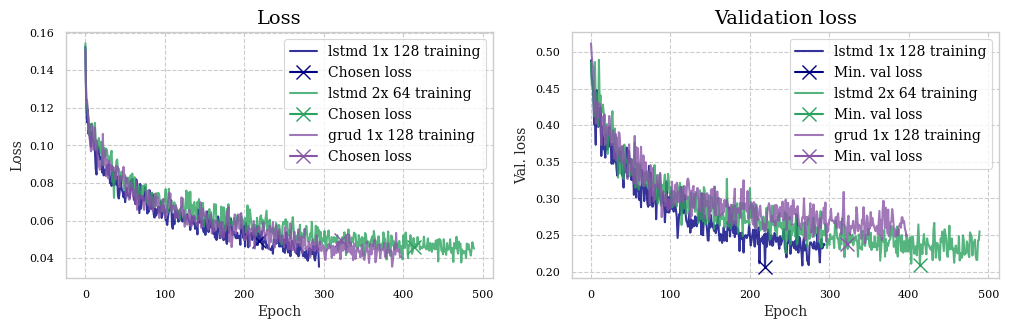

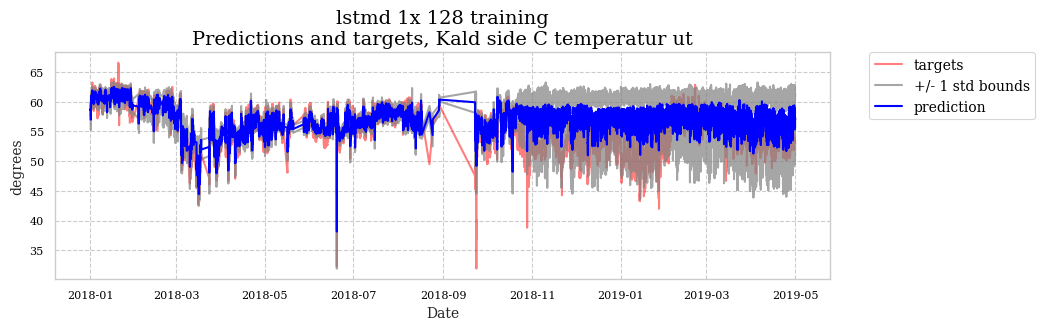

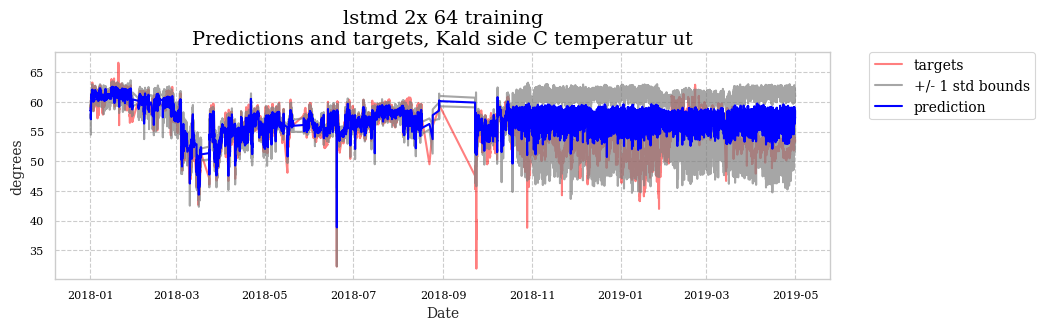

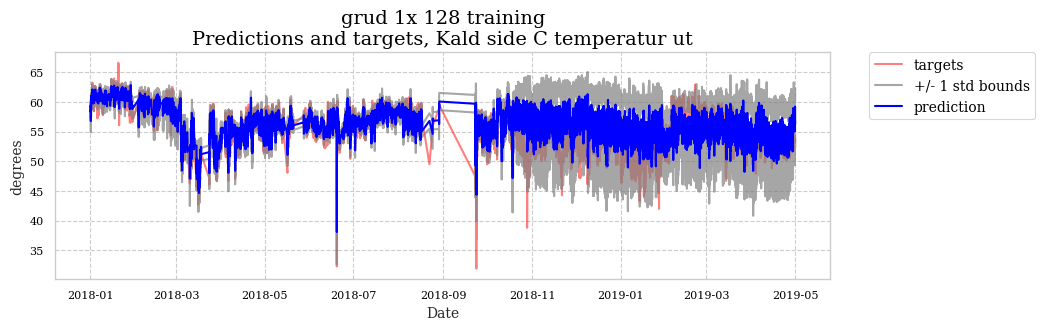

In [1]:
# %load example_F_predict_with_uncertainty.py
import src.core as mlApi

# 1. Define dataset specifics

# File path to dataset .csv
filename = "../master-thesis-db/datasets/F/data2_30min.csv"

# List of columns on form ['name', 'desc', 'unit']
columns = [
	['FYN0111', 'Gasseksport rate', 'MSm^3/d'],
	['FT0111', 'Gasseksport molvekt','g/mole'],
	['TT0102_MA_Y', 'Varm side A temperatur inn', 'degrees'],
	['TIC0101_CA_YX', 'Varm side A temperatur ut', 'degrees'],
	['TT0104_MA_Y', 'Varm side B temperatur inn', 'degrees'],
	['TIC0103_CA_YX', 'Varm side B temperatur ut', 'degrees'],
	['TT0106_MA_Y', 'Varm side C temperatur inn', 'degrees'],
	['TIC0105_CA_YX', 'Varm side C temperatur ut', 'degrees'],
	['TI0115_MA_Y', 'Scrubber temperatur ut', 'degrees'],
	['PDT0108_MA_Y', 'Varm side A trykkfall', 'Bar'],
	['PDT0119_MA_Y', 'Varm side B trykkfall', 'Bar'],
	['PDT0118_MA_Y', 'Varm side C trykkfall', 'Bar'],
	['PIC0104_CA_YX', 'Innløpsseparator trykk', 'Barg'],
	['TIC0425_CA_YX', 'Kald side temperatur inn', 'degrees'],
	['TT0651_MA_Y', 'Kald side A temperatur ut', 'degrees'],
	['TT0652_MA_Y', 'Kald side B temperatur ut', 'degrees'],
	['TT0653_MA_Y', 'Kald side C temperatur ut', 'degrees'],
	['TIC0101_CA_Y', 'Kald side A ventilåpning', '%'],
	['TIC0103_CA_Y', 'Kald side B ventilåpning', '%'],
	['TIC0105_CA_Y', 'Kald side C ventilåpning', '%'],
]

# List of column names to ignore completely
irrelevantColumns = [
		'FT0111',
		'PDT0108_MA_Y',
		'PDT0119_MA_Y',
		'PDT0118_MA_Y',
		'TT0104_MA_Y',
		'TIC0103_CA_YX',
		'TI0115_MA_Y',
		'TT0652_MA_Y',
		'TIC0103_CA_Y',
		'PIC0104_CA_YX',
		'TIC0101_CA_Y',
		'TT0102_MA_Y',
		'TIC0101_CA_YX',
		'TT0651_MA_Y',
]

# List of column names used as targets
targetColumns = [
    'TT0653_MA_Y'
]

# List of training periods on form ['start', 'end']
traintime = [
        ["2018-01-01 00:00:00", "2018-08-01 00:00:00"],
    ]

# Testing period
testtime = [
    "2018-01-01 00:00:00",
    "2019-05-01 00:00:00"
]

# 2. Initiate and divide data
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models | NB: only RNN (LSTM/GRU) models
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

# 4. Initiate and train models
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

# 5. Predict
predictions, means, stds = mlApi.predictWithModelsUsingDropout()

# 6. Plot predictions for each model
for i in range(len(modelList)):
	output_mean = means[i]
	output_std = stds[i]

	for j in range(output_mean.shape[-1]):
		mean = output_mean[:, j]
		std = output_std[:, j]

		import numpy as np

		upper = np.add(mean, std)
		lower = np.subtract(mean, std)

		import matplotlib.pyplot as plt

		fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100)
		ax.set_xlabel('Date')
		ax.set_ylabel(mlApi._columnUnits[targetColumns[j]])
		ax.set_title(modelList[i].name + "\nPredictions and targets, " + mlApi._columnDescriptions[targetColumns[j]])
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, y_test[mlApi._maxEnrolWindow:, j], color="red", alpha=0.5, label="targets")
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, upper, color="grey", alpha=0.7, label="+/- 1 std bounds")
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, lower, color="grey", alpha=0.7)
		ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, mean, color="blue", alpha=1.0, label="prediction")
		ax.grid(1, axis='y')
		ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
		
		plt.show()